https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df = df[5::6].copy()

In [5]:
date_time = pd.to_datetime(df.pop("Date Time"), format='%d.%m.%Y %H:%M:%S')

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [7]:
df.loc[df["wv (m/s)"] == -9999.0, "wv (m/s)"] = 0
df.loc[df["max. wv (m/s)"] == -9999.0, "max. wv (m/s)"] = 0

In [8]:
wv = df.pop("wv (m/s)")
max_wv = df.pop("max. wv (m/s)")

In [9]:
wd_rad = df.pop("wd (deg)")*np.pi / 180

In [10]:
# creating wind Vector by combining wind direction and velocity
df["Wx"] = wv*np.cos(wd_rad)
df["Wy"] = wv*np.sin(wd_rad)

df["max Wx"] = max_wv*np.cos(wd_rad)
df["max Wy"] = max_wv*np.sin(wd_rad)

In [11]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

using sin, cos to convert time to clear "Time of day" and "Time of year" signal ????? why? and what is it doing exactly?

In [12]:
day = 24*60*60
year = (365.2425)*day

In [13]:
df["Day sin"] = np.sin(timestamp_s * (2*np.pi / day))
df["Day cos"] = np.cos(timestamp_s * (2*np.pi / day))

df["Year sin"] = np.sin(timestamp_s * (2*np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2*np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

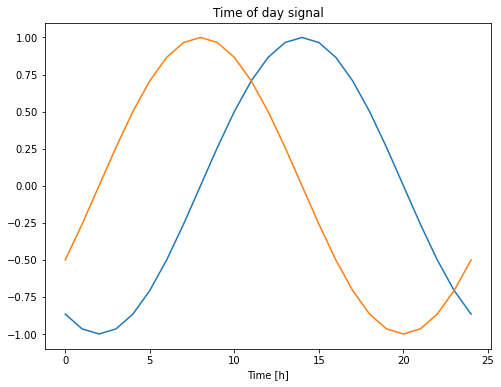

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In this case we knew ahead of time which frequencies were important, if you didn't know you can find out using an `fft`↓ 

1. Understand why we need to convert to frequencies in the first place ?
2. What does it mean to be "important frequency"  ?
3. How tf.signal.rfft finds important frequency   ?

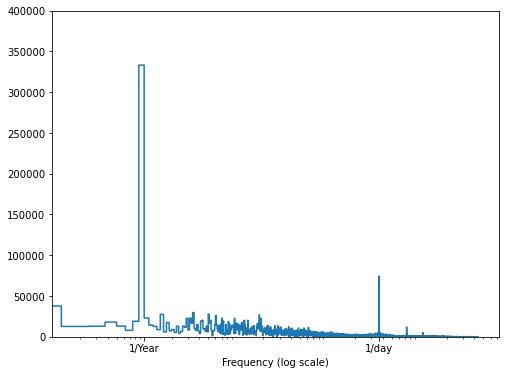

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [16]:
column_indices = {name:i for i, name in enumerate(df.columns)}

In [17]:
n = len(df)
train_df = df[0:int(n*0.7)].copy()
val_df   = df[int(n*0.7):int(n*0.9)].copy()
test_df  = df[int(n*0.9):].copy()

## Normalize data

Normalization, one way of scaling: $\frac{X-Xmean}{Xstd}$

mean, and std_dev should only be computed using <b> training data </b> so model knows nothing about validation, test sets.

In [18]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,-0.866025,-5.000000e-01,0.003598,0.999994
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,-0.965926,-2.588190e-01,0.004315,0.999991
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,-1.000000,7.867334e-13,0.005032,0.999987
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,-0.965926,2.588190e-01,0.005749,0.999983
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,-0.866025,5.000000e-01,0.006465,0.999979


In [19]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df   = (val_df - train_mean) / train_std
test_df  = (test_df - train_mean) / train_std

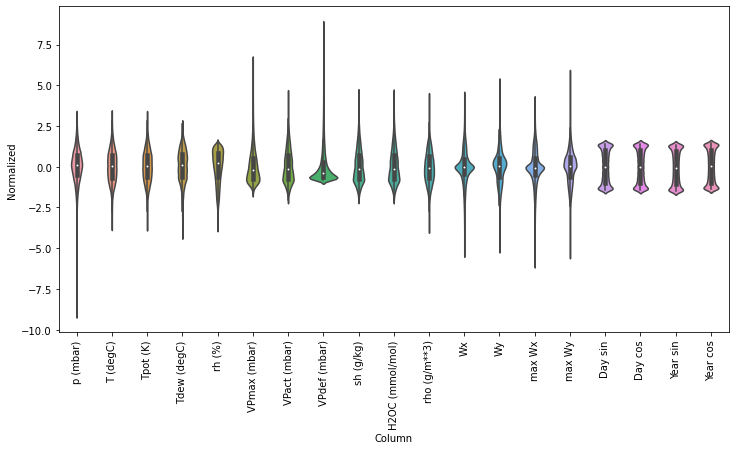

In [20]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [21]:
df_std.head() #melted version

,Column,Normalized
0,p (mbar),0.945308
1,p (mbar),0.959770
2,p (mbar),0.986284
3,p (mbar),1.004362
4,p (mbar),1.061006


## Data windowing

Main features of input windows:
- length of input and output
- Time offset between them.  --> What is offset???
- Which features are used as inputs, output, or both

In [22]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # label column indicies
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name:i for i, name in enumerate(label_columns)}
            
        self.column_indices = {name:i for i, name in enumerate(train_df.columns)}
        
        # window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        # slice ??
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f"Total window size: {self.total_window_size}",
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [23]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=["T (degC)"])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['T (degC)'])

In [24]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [25]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [26]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns],
                           axis=-1)
        
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

In [27]:
# What is this doing? is it adding a function to WindowGenerator class?
WindowGenerator.split_window = split_window

why [0:7] then [100:107], [200:207] ? what about all rows between them?

In [28]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


above, label has one feature(single output) because `WindowGenerator` was initialized with one label_column ["T (degC)"]

In [29]:
w2.example = example_inputs, example_labels

In [30]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [31]:
w2.input_indices

array([0, 1, 2, 3, 4, 5])

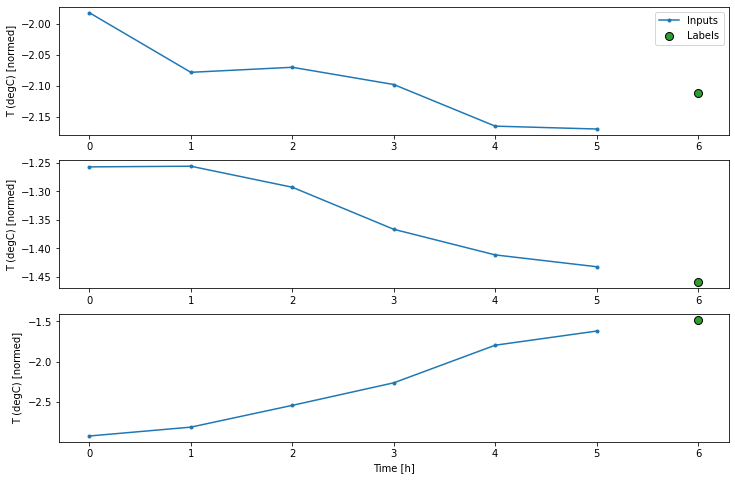

In [32]:
w2.plot()

# Creating tf.data.Datasets

clearly understand benefits of tf.data.Datasets as it is used in almost all tutorials

In [33]:
def make_dataset(self, data):
    """ convert time series df to tf.data.Dataset of (input_window, label_window) pairs."""
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32)
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [34]:
# learn about classes and decorators

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, "_example", None)
    if result is None:
        result = next(iter(self.train))
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [35]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [36]:
# iterting over a Dataset yields concrete batches
# ↑↑ ????
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


# Models

## Single step models

predict single value (1 timestep) into the future based only on current condition.

In [37]:
single_step_window = WindowGenerator(input_width=1,
                                     label_width=1,
                                     shift=1,
                                     label_columns=["T (degC)"])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

single_step_window contain train,val,test but why do they all have same number of input and output? shouldn't we use 70%, 15%, 15%?

In [38]:
single_step_window.val

<MapDataset shapes: ((None, 1, 19), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [39]:
single_step_window.train

<MapDataset shapes: ((None, 1, 19), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [40]:
single_step_window.test

<MapDataset shapes: ((None, 1, 19), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [41]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

## Baseline model

predict 1h into future given current value of all features

We will start our model by predicting current temperature as prediction meaning prediction = "No change" which is reasonable because temperature changes slowly. It will work less well if you make prediction further in the future

In [42]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index= None):
        super().__init__()  # super ???
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:,:, tf.newaxis] # tf.newaxis ??

In [43]:
# WHat is this doing...?
baseline = Baseline(label_index=column_indices["T (degC)"])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0) # verbose?

439/439 [==============================] - 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [44]:
baseline.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [46]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=["T (degC)"]
)

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

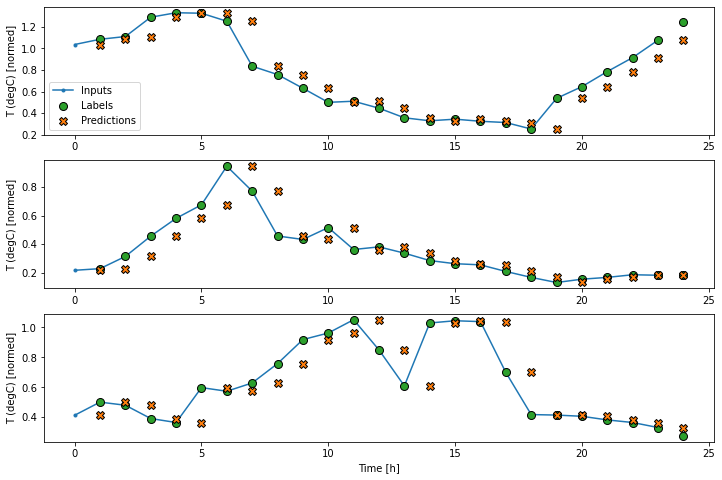

In [50]:
wide_window.plot(baseline)

## Linear model

- insert linear transformation between input and output.
- layers.Dense with no activation set is a `Linear model`
- ?? layer only transforms last axis of data from `(batch,time, inputs)` to `(btach, time, units)`. It is applied independently to every item across the `batch` and `time` axes
- ??In this case output from time step only depeneds on that step



In [51]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [52]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [54]:
MAX_EPOCHS = 20


# patience?
def compile_and_fit(model, window, patience=2):
    
    # ↓ ??
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data = window.val,
                        callbacks=[early_stopping])
    return history

In [55]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.2588 - mean_absolute_error: 0.2756 - val_loss: 0.0220 - val_mean_absolute_error: 0.1122
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0157 - mean_absolute_error: 0.0946 - val_loss: 0.0119 - val_mean_absolute_error: 0.0823
Epoch 3/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0102 - mean_absolute_error: 0.0750 - val_loss: 0.0090 - val_mean_absolute_error: 0.0708
Epoch 4/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0087 - val_mean_absolute_error: 0.0685
Epoch 5/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0695 - val_loss: 0.0087 - val_mean_absolute_error: 0.0691
Epoch 6/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0687
Epoc

In [56]:
val_performance["Linear"] = linear.evaluate(single_step_window.val)
performance["Linear"] = linear.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 0s 1ms/step - loss: 0.0087 - mean_absolute_error: 0.0688
